In [1]:
# These codes are adapted from Sagawa and Hino's work: https://github.com/ssgw320/gdacnf

In [2]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
def load_datasets(filename="dataset.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data["datasets"], data["time_points"]

In [4]:
datasets, time_points = load_datasets('./yearbook.pkl')
domain_0_X, domain_0_Y = datasets[0][0], datasets[0][1]
domain_0_X.shape, domain_0_Y.shape

((154, 32, 32, 1), (154,))

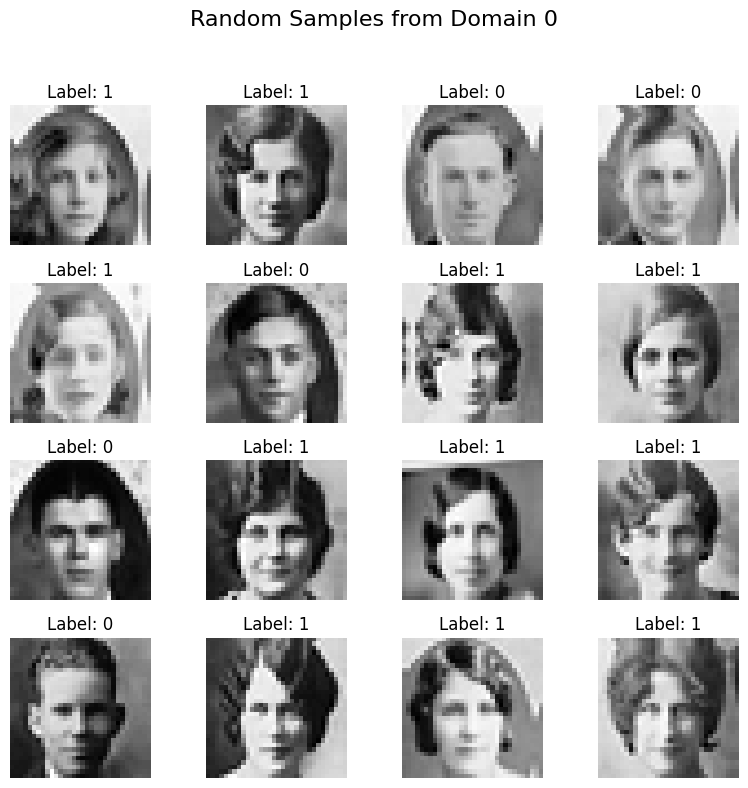

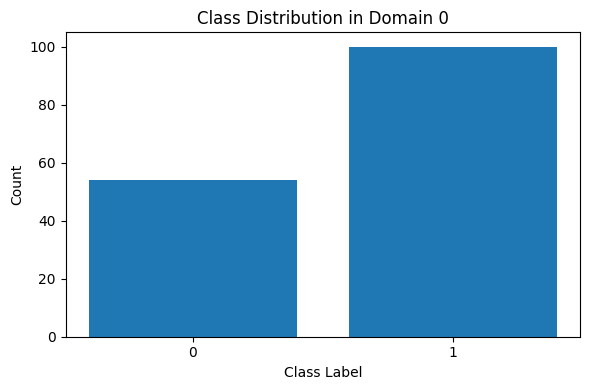

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 이미 load_datasets()로 불러왔다는 가정
# domain_0_X.shape == (154, 32, 32, 1), domain_0_Y.shape == (154,)

# 1) 랜덤 샘플 시각화
num_samples = 16
indices = np.random.choice(domain_0_X.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax, idx in zip(axes.flatten(), indices):
    img = domain_0_X[idx].squeeze()   # (32,32)
    label = domain_0_Y[idx]
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.suptitle("Random Samples from Domain 0", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2) 클래스 분포 시각화
unique_labels = np.unique(domain_0_Y)
counts = [np.sum(domain_0_Y == lbl) for lbl in unique_labels]

plt.figure(figsize=(6,4))
plt.bar(unique_labels.astype(str), counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution in Domain 0")
plt.tight_layout()
plt.show()

In [6]:
paths = []
for i in df[:18000]['img_path']:
    paths.append("portraits/%s/%s" % (i.parent.stem.split('portraits\\')[-1] , i.stem))

In [7]:
def make_split_data(df: pd.DataFrame, target: str, num_inter_domain: int, num_domain_samples: dict):
    split_index = np.split(np.arange(df.shape[0]), np.cumsum(list(num_domain_samples.values())))
    x_all, y_all, year_all = [], [], []
    for idx, key in zip(split_index, num_domain_samples.keys()):
        x = df.drop(columns=[target]).loc[idx]  # 여기에는 img_path랑 year만 남음
        y = df.loc[idx, target].values
        years = x['year'].values
        if key == 'inter':
            x_splits = np.array_split(x, num_inter_domain)
            y_splits = np.array_split(y, num_inter_domain)
            year_splits = np.array_split(years, num_inter_domain)
            x_all.extend(x_splits)
            y_all.extend(y_splits)
            year_all.extend(year_splits)
        else:
            x_all.append(x)
            y_all.append(y)
            year_all.append(years)
    return x_all, y_all, year_all

In [8]:
def convert_portraits(p: Path):
    # read, gray scale, resize
    img = Image.open(p).convert('L').resize((32,32))
    img = np.array(img, dtype=np.float32) / 255
    return img

In [9]:
num_domain_samples = {'source': 2000, 'inter': 14000, 'target': 2000}
# split to each domain

x_all, y_all, year_all = make_split_data(df, 'sex', 7, num_domain_samples)

for i, domain in enumerate(x_all):
    images = [convert_portraits(Path(p)) for p in domain['img_path']]
    x_all[i] = np.stack(images).reshape(-1, 1, 32, 32)

/home/jslee/miniconda3/envs/toy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
obj = {'data': x_all, 'label': y_all, 'year': year_all}
pd.to_pickle(obj, 'portraits_original.pkl')

In [11]:
pd.to_pickle(paths, f'portraits_path.pkl')

In [12]:
import umap

2025-06-08 18:28:58.390071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 18:28:58.403863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-08 18:28:58.424166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-08 18:28:58.424201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 18:28:58.437321: I tensorflow/core/platform/cpu_feature_gua

In [13]:
def fit_umap(x_all, y_all, **umap_kwargs) -> list:
    umap_settings = dict(n_components=2, n_neighbors=15, metric='cosine')
    umap_settings.update(umap_kwargs)
    X = np.vstack(x_all)
    X = X.reshape(X.shape[0], -1)
    # use source label as semi-superviesd UMAP
    Y_semi_supervised = [np.full(shape=y.shape[0], fill_value=-1) for y in y_all]
    Y_semi_supervised[0] = y_all[0].copy()
    Y_semi_supervised = np.hstack(Y_semi_supervised)
    # fit UMAP
    encoder = umap.UMAP(random_state=1234, **umap_settings)
    Z = encoder.fit_transform(X, Y_semi_supervised)
    z_idx = np.cumsum([i.shape[0] for i in x_all])
    z_all = np.vsplit(Z, z_idx)[:-1]
    return z_all, encoder

In [14]:
z_all, encoder = fit_umap(np.array(x_all)[[0, len(x_all)-1]], np.array(y_all)[[0, len(y_all)-1]], n_components=8)

/home/jslee/miniconda3/envs/toy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jslee/miniconda3/envs/toy/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jslee/miniconda3/envs/toy/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
obj = {'data': z_all, 'label': np.array(y_all)[[0, len(y_all)-1]]}
pd.to_pickle(obj, f'portraits.pkl')

In [3]:
import pickle
import numpy as np
from pathlib import Path

# Locate pickle files in current directory
pkl_files = list(Path('.').glob('portraits_*.pkl')) + list(Path('.').glob('portraits.pkl'))

if not pkl_files:
    print("No pickle files found in the current directory.")
    print("Please ensure 'portraits_original.pkl', 'portraits_path.pkl', and 'portraits.pkl' are present.")
else:
    for pkl in pkl_files:
        print(f"--- Inspecting {pkl.name} ---")
        try:
            obj = pickle.load(open(pkl, 'rb'))
        except Exception as e:
            print(f"  Error loading {pkl.name}: {e}")
            continue

        # If dict, print keys and summary
        if isinstance(obj, dict):
            print("Type: dict")
            for k, v in obj.items():
                print(f"  Key: '{k}' → Type: {type(v)}")
                if isinstance(v, list):
                    print(f"    List length: {len(v)}")
                    if len(v) > 0 and isinstance(v[0], np.ndarray):
                        shapes = [arr.shape for arr in v[:3]]
                        print(f"    Example shapes: {shapes}")

                    # If key is year, print min/max per domain
                    if k == "year":
                        for i, year_list in enumerate(v):
                            year_array = np.array(year_list)
                            print(f"    Domain {i}: year range [{year_array.min()} - {year_array.max()}]")
                elif isinstance(v, np.ndarray):
                    print(f"    ndarray shape: {v.shape}")
                else:
                    print("    (Other type)")

        elif isinstance(obj, list):
            print("Type: list")
            print(f"  Length: {len(obj)}")
            if len(obj) > 0:
                print(f"  Element type: {type(obj[0])}")
                if isinstance(obj[0], np.ndarray):
                    print(f"  Example shape: {obj[0].shape}")
        else:
            print(f"Type: {type(obj)}, repr: {repr(obj)}")
        print()

--- Inspecting portraits_original.pkl ---
Type: dict
  Key: 'data' → Type: <class 'list'>
    List length: 9
    Example shapes: [(2000, 1, 32, 32), (2000, 1, 32, 32), (2000, 1, 32, 32)]
  Key: 'label' → Type: <class 'list'>
    List length: 9
    Example shapes: [(2000,), (2000,), (2000,)]
  Key: 'year' → Type: <class 'list'>
    List length: 9
    Example shapes: [(2000,), (2000,), (2000,)]
    Domain 0: year range [1905 - 1935]
    Domain 1: year range [1935 - 1942]
    Domain 2: year range [1942 - 1945]
    Domain 3: year range [1945 - 1950]
    Domain 4: year range [1950 - 1955]
    Domain 5: year range [1955 - 1960]
    Domain 6: year range [1960 - 1965]
    Domain 7: year range [1965 - 1969]
    Domain 8: year range [1969 - 1973]

--- Inspecting portraits_path.pkl ---
Type: list
  Length: 18000
  Element type: <class 'str'>

--- Inspecting portraits.pkl ---
Type: dict
  Key: 'data' → Type: <class 'list'>
    List length: 2
    Example shapes: [(2000, 8), (2000, 8)]
  Key: 'label